# Motor Vehicle Collisions

### Load the Workspace

In [1]:
import re
import datetime as dt
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud

from zipfile import ZipFile

from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from fbprophet import Prophet
from pmdarima import auto_arima

### Load the dataset

In [2]:
with ZipFile('nyc_collisions.csv.zip', 'r') as zip_file:
    with zip_file.open('nyc_collisions.csv') as file:
        df = pd.read_csv(file, low_memory=False)

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df = df.assign(
    borough=lambda x: x.borough.str.title(),
    crash_datetime=lambda x: pd.to_datetime(x.crash_datetime),
    zip_code=lambda x: x.zip_code.str.strip(),
    person_sex=lambda x: x.person_sex.fillna('U'),
    state_registration=lambda x: x.state_registration.fillna(x.state_registration.mode()),
    vehicle_type=lambda x: x.vehicle_type.str.title(),
)
    
df = df.drop(
    index=list(df.loc[df.zip_code==''].index)
).assign(
    zip_code=lambda x: x.zip_code.astype(int)
).set_index('crash_datetime').sort_index()

df.head()

,collision_id,borough,zip_code,latitude,longitude,person_type,person_sex,person_injury,person_age,state_registration,...,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,ejection,emotional_status,bodily_injury,position_in_vehicle
crash_datetime,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:30:00,5292,Manhattan,10007,40.714678,-74.005887,Occupant,U,Injured,31,NY,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
2012-07-01 00:30:00,5292,Manhattan,10007,40.714678,-74.005887,Occupant,U,Injured,31,NJ,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
2012-07-01 00:37:00,37633,Manhattan,10017,40.755924,-73.974889,Occupant,U,Injured,36,NY,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
2012-07-01 00:37:00,37633,Manhattan,10017,40.755924,-73.974889,Occupant,U,Injured,36,NJ,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
2012-07-01 01:00:00,85161,Bronx,10456,40.828729,-73.914723,Occupant,U,Injured,36,NY,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN


In [4]:
vehicle_type_map = [
    (['Sport Utility / Station Wagon', 'Multi-Wheeled Vehicle', 'Wagon', 'Suv', 'Subur', 'Subn', 'Subn/', 'Jeep'], 'Station Wagon/Sport Utility Vehicle'),
    (['Tractor Truck Gasoline', 'Tractor Truck Diesel', 'Bulk Agriculture', 'Tract', 'Trac', 'Tractor', 'Tractor Tr', 'Ems', 'Emt'], 'Tractor Truck'),
    (['4 Dr Sedan', '2 Dr Sedan', 'Motor', 'Stree', 'Self', '4Dr', '3-Door', '3 Whe', '4Ds', '4D'], 'Sedan'), 
    (['E-Sco', 'Electric S', 'E Sco', 'Escooter', 'E Scooter'], 'E-Scooter'),
    (['E-Bik', 'Elect', 'E Bik', 'Ebike', 'Elec'], 'E-bike'),
    (['Limo', 'Limou'], 'Limousine'),
    (['Schoo'], 'School Bus'),
    (['Firet', 'Firetruck', 'Fire', 'Fdny', 'Fdny Truck', 'Fdny Fire', 'Fdny Engin', 'Fdny Ambul', 'Fd Truck', 'Nyc F', 'Fdny Ems', 'Fdny Ladde', 'Fd Tr', 'Fire Engin', 'Ladder Tru', 'Nyfd', 'Firtruck', 'Fdny #226', 'Fdny Firet', 'Fdny Rig', 'Ladder'], 'Fire Truck'),
    (['Bike', 'Minibike', 'Minicycle'], 'Bicycle'),
    (['Ambul', 'Ambu', 'Amb', 'Ambulence', 'Nys Ambula', 'Nyc Ambula', 'Nyc A', 'Ambulace', 'Embulance'], 'Ambulance'),
    (['Pk', 'Pick', 'Picku', 'Ford', 'Pick Up', 'Pickup', 'Pick Up Tr', 'Pickup', 'Pick-', 'Pickup Tru', 'Pick-Up Tr'], 'Pick-Up Truck'),
    (['Dump', 'Garbage Or Refuse', 'Dump Truck', 'Sanit', 'Garba', 'Dumps', 'Garbage Tr', 'Sanitation', 'G Tow', 'Dumpt', 'Nyc Sanita'], 'Garbage Truck'),
    (['Flat Bed', 'Stake Or Rack', 'Open Body', 'Flat Rack', 'Flat', 'Flatbed', 'Flatb'], 'Flatbed Truck'),
    (['Livery Vehicle', 'Pedicab'], 'Taxi'),
    (['Tow Truck / Wrecker', 'Tow T', 'Tow', 'Tower'], 'Tow Truck'),
    (['Small Com Veh(4 Tires)', 'Chassis Cab', 'Usps', 'Deliv', 'Comme', 'Com', 'Comm', 'Delv', 'Utili', 'Pickup With Mounted Camper', 'Util', 'Posta', 'Us Po', 'Mail', 'Usps Truck', 'Glass Rack', 'Livestock Rack', 'Postal Tru', 'Nyc D', 'Delivery T', 'Mail Truck', 'Us Postal', 'Delivery', 'Fedex', 'Commercial', 'Utility Tr', 'Com T', 'Comer', 'Usps Mail', 'Fedex Truc', 'Usp M', 'Ups'], 'Medium Duty Commercial Truck'),
    (['Large Com Veh(6 Or More Tires)', 'Forkl', 'Mack', 'Power', 'Freig', 'Fork','Cargo', 'Forklift', 'Uhaul', 'Power Shov', 'Semi', 'Semi-', 'U-Hau', 'Fork Lift', '18 Wh', '8X20', 'Movin', 'Uhual', 'Semitraile'], 'Heavy Duty Commercial Truck'),
    (['Trail', 'Trailer', 'Trl', 'Trlr', 'Trailor', 'Tlr'], 'Trailer Truck'),
    (['Lift Boom', 'Boom'], 'Boom Lift'),
    (['Scoot', 'Pallet', 'Scoo', 'Scotter', 'Gas Scoote'], 'Scooter'),
    (['Box T', 'Box', 'Boxtr'], 'Box Truck'),
    (['Pas', 'Pass', 'Pas V', 'Passe'], 'Passenger Vehicle'),
    (['Tanker', 'Tank'], 'Tanker Truck'),
    (['Beverage Truck', 'Lunch Wagon', 'Food', 'Food Cart'], 'Food Truck'),
    (['Trk', 'Tk', 'Vehicle Tr', 'Truck Van', 'Track'], 'Truck'),
    (['Rv', 'Motorized Home', 'Motor Home'], 'RV'),
    (['Van T', 'Miniv', 'Refrigerated Van', 'Van Camper', 'Refg', 'Vanette', 'Van/T', 'Refri', 'Work Van', 'Vav', 'Van Ford', 'Van Truck', 'Van F', 'Cargo Van', 'Transit Va', 'School Van', 'Vam', 'Mini Van'], 'Van'),
    (['Mta B', 'Mta Bus', 'Omnib', 'Ems Bus'], 'Bus'),
    (['Cemen', 'Cmix', 'Cement Tru', 'Cmixer', 'Concrete M'], 'Concrete Mixer'),
    (['Mopd', 'Mopet'], 'Moped')
]

def map_vehicle_type(x):
    for key_list, value in vehicle_type_map:
        if x in key_list:
            return value
    return x

vehicle_types = df.assign(
    vehicle_type=lambda x: x.vehicle_type.astype(str).str.title().apply(map_vehicle_type)
).vehicle_type.value_counts(dropna=False).iloc[:40].index.tolist()

In [5]:
df = df.assign(
    vehicle_type=lambda x: x.vehicle_type.astype(str).str.title().apply(map_vehicle_type),
    vehicle_year=lambda x: np.where(
        x.vehicle_year > 2021,
        x.index.year,
        x.vehicle_year
    ),
    number_of_persons_injured=lambda x: x.number_of_persons_injured.fillna(0),
    number_of_persons_killed=lambda x: x.number_of_persons_killed.fillna(0),
).assign(
    vehicle_type=lambda x: np.where(
        x.vehicle_type.isin(vehicle_types),
        x.vehicle_type, 'Other'
    )
).assign(
    vehicle_type=lambda x:  x.vehicle_type.str.replace('Unknown', 'Other').str.replace('Unkno', 'Other')
).map(lambda x: x.strip().title() if isinstance(x, str) else x)

In [6]:
drop_index = df.loc[df.latitude==0].index
df = df.drop(index=drop_index)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787430 entries, 2012-07-01 00:30:00 to 2021-12-04 23:58:00
Data columns (total 40 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   collision_id                   int64  
 1   borough                        object 
 2   zip_code                       int64  
 3   latitude                       float64
 4   longitude                      float64
 5   person_type                    object 
 6   person_sex                     object 
 7   person_injury                  object 
 8   person_age                     int64  
 9   state_registration             object 
 10  vehicle_type                   object 
 11  vehicle_year                   float64
 12  travel_direction               object 
 13  vehicle_occupants              float64
 14  driver_sex                     object 
 15  driver_license_status          object 
 16  driver_license_jurisdiction    object 
 17  pre_crash    

In [8]:
df.isnull().sum()

collision_id                           0
borough                                0
zip_code                               0
latitude                               0
longitude                              0
person_type                            0
person_sex                             0
person_injury                          0
person_age                             0
state_registration                 81886
vehicle_type                           0
vehicle_year                      348110
travel_direction                  256076
vehicle_occupants                 278685
driver_sex                        496253
driver_license_status             590043
driver_license_jurisdiction       571143
pre_crash                         149961
point_of_impact                   262873
vehicle_damage                    269304
vehicle_damage_1                 1169321
vehicle_damage_2                 1608799
vehicle_damage_3                 1906152
public_property_damage            234455
contributing_fac

### Exploratory Analysis

We'll respond to the following questions:
1. Which location has the most accidents?
2. Which time has the most accidents?
3. Which day of the week has the most accidents?
4. How many victims on average per accident?
5. Registration Year for cars in accidents.
6. Reasons for accidents.
7. For vehicles from x year, what is the likelihood of accidents?
8. Which street corner / intersection is prone to accidents?
9. Gender split for Accidents.
10. What are the most contributing factors for accidents?
11. Which vehicles contribute the most to accidents?
12. Accident Trends over time
13. Injured vs Killed stats
14. Relationship between Complainant and person injured
15. Vehicle Damage vs Vehicle Make, Vehicle Type, Registration Year, Driver Sex, Point of Impact and Travel Direction
16. Driver Licence jurisdictions and accidents
17. Understanding these features - Ejection, Emotional status, Bodily injury, Position in vehicle, Safety equipment, Ped role
18. Provide recommendations to reduce the occurrence of accidents

Plotting Colors:

In [9]:
deep_colors = [
    '#4C72B0', '#55A868', '#C44E52',
    '#8172B2', '#CCB974', '#64B5CD'
]

1. Which location has the most accidents?

We have a number of location-based features:
* Longitude & Latitude
* on street name & cross street name

We'll begin by plotting a location-based heatmap of accidents.

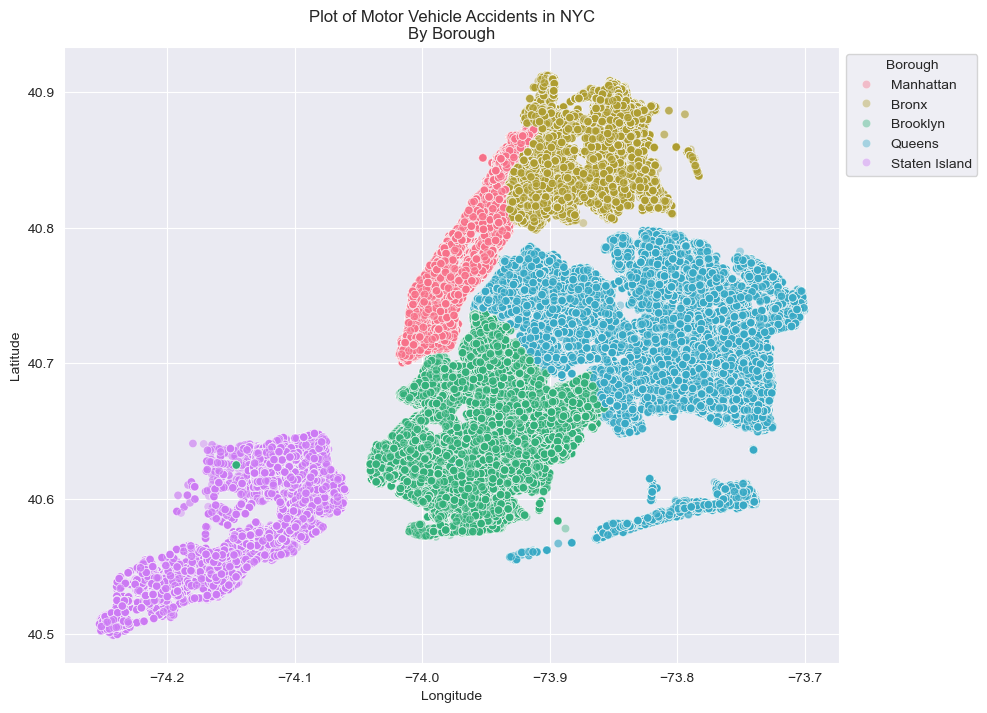

In [10]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='borough', alpha=.4
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Motor Vehicle Accidents in NYC\nBy Borough')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Borough")
plt.show()

Most accidents are with Licensed drivers:

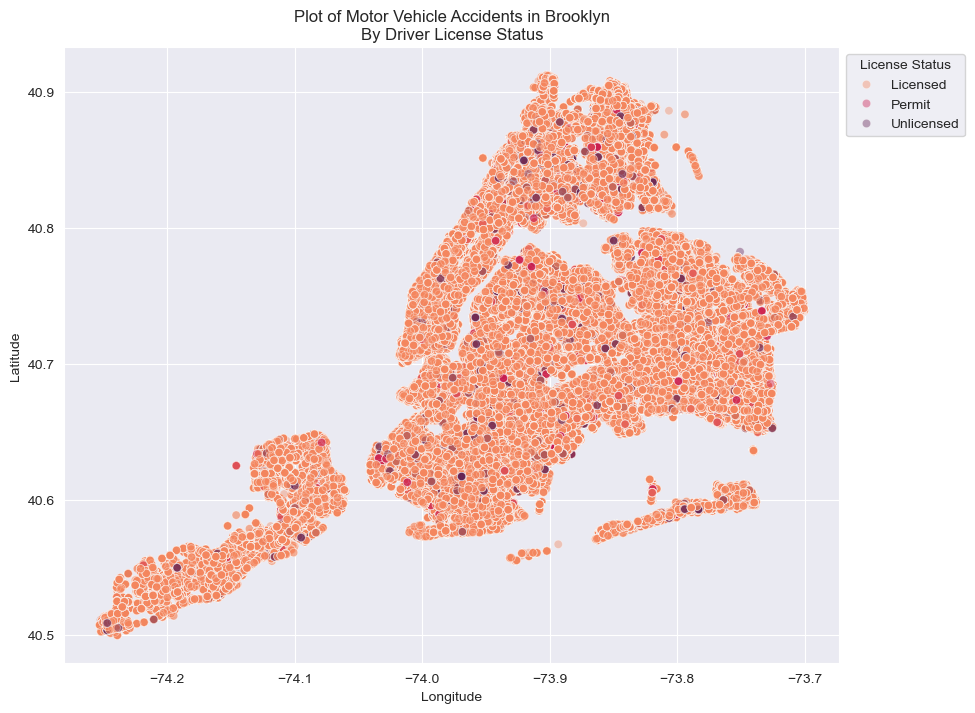

In [11]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='driver_license_status', palette='rocket_r', 
    alpha=.4
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Motor Vehicle Accidents in Brooklyn\nBy Driver License Status')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="License Status")
plt.show()

Most accidents are by male drivers:

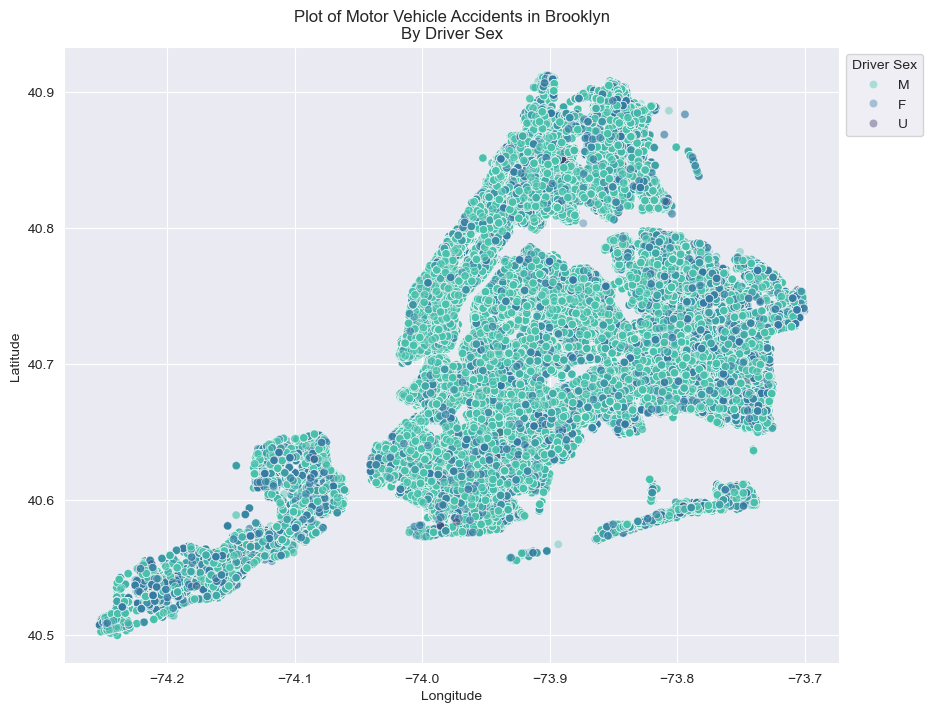

In [12]:
sns.set_palette([deep_colors[0]])
sns.set_style("darkgrid", {"grid.alpha": 0.2})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df, x='longitude', y='latitude',
    hue='driver_sex', palette='mako_r', 
    alpha=.4
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Motor Vehicle Accidents in Brooklyn\nBy Driver Sex')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Driver Sex")
plt.show()

**Most Popular Accident Intersections**

Most accidents occur around Flatbush Avenue Extension & Tillary Street (3708). This intersection is home to 2 hotels and a park. It has a traffic light and a speed limit of 25mph. The intersection is featured in a legal article on [dangerous intersections](https://www.thebarnesfirm.com/tillary-st-flatbush-ave-dangerous-intersections/#:~:text=drivers%20at%20risk.-,Speed,at%20risk%20of%20an%20accident).

Located just off I-278, this intersection has a lot of traffic coming from and going to the high-speed interstate; but these are surface streets with a 25mph speed limit. With nearby parks and hotels, this intersection also features a lot of foot traffic, making it even more dangerous for pedestrians crossing the street.

Since much of the traffic here is coming from the Manhattan Bridge or Interstate 278, many of the vehicles here may be moving much faster than what the speed limit permits.

The Bronx Borough has the majority of accident intersections.

In [13]:
combinations = df.groupby(['on_street_name', 'cross_street_name', 'borough']).size().reset_index(name='Count')

most_common = combinations.sort_values(
    by='Count', ascending=False
).assign(
    accident_intersection=lambda x: x.on_street_name + " - " +  x.cross_street_name,
).reset_index(drop=True)[
    ['accident_intersection', 'borough', 'Count']
]

top10 = most_common.head(10)
top10

,accident_intersection,borough,Count
0,West Fordham Road - Major Deegan Expressway,Bronx,2905
1,Flatbush Avenue Extension - Tillary Street,Brooklyn,1966
2,Bruckner Boulevard - Hunts Point Avenue,Bronx,1938
3,Rockaway Boulevard - Brewer Boulevard,Queens,1907
4,Tillary Street - Flatbush Avenue Extension,Brooklyn,1742
5,North Conduit Avenue - Cohancy Street,Queens,1626
6,Rockaway Boulevard - Farmers Boulevard,Queens,1622
7,East Gun Hill Road - Bronx River Parkway,Bronx,1598
8,Atlantic Avenue - Eastern Parkway,Brooklyn,1438
9,Hunts Point Avenue - Bruckner Boulevard,Bronx,1403


In [14]:
top10.borough.value_counts()

borough
Bronx       4
Brooklyn    3
Queens      3
Name: count, dtype: int64

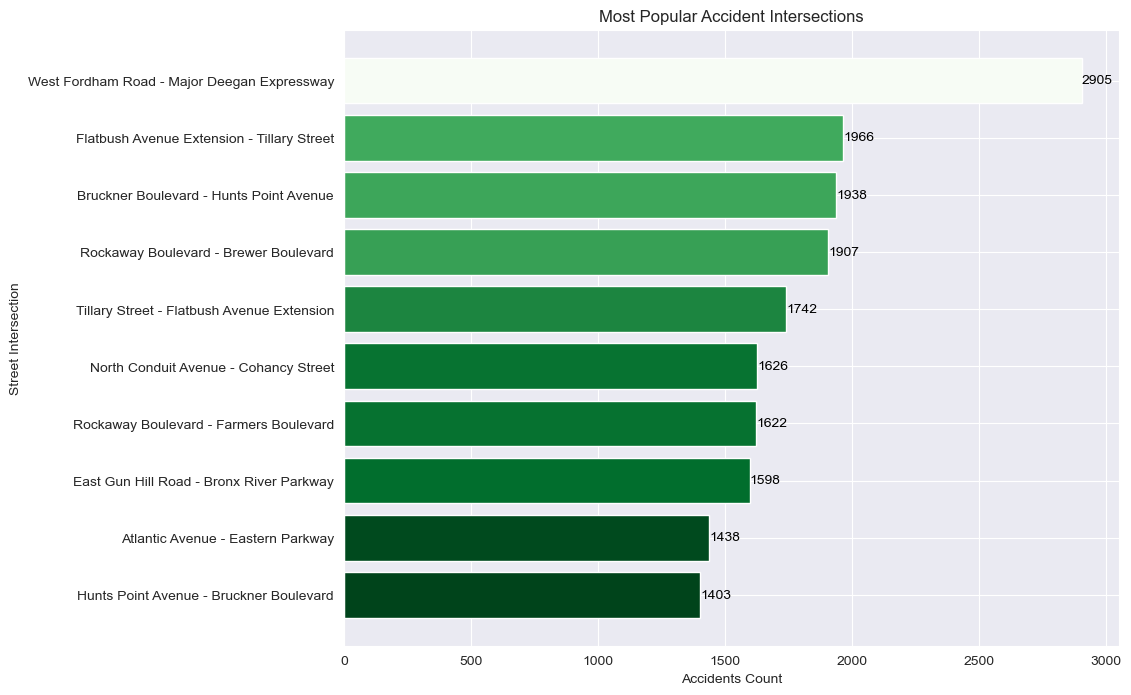

In [15]:
cmap = plt.get_cmap('Greens_r')
normalize = plt.Normalize(min(top10.Count), max(top10.Count))

plt.figure(figsize=(10, 8))
plt.barh(
    top10.accident_intersection,
    top10.Count,
    color=cmap(normalize(top10.Count)), edgecolor='white'
)
for i, v in enumerate(top10.Count.tolist()):
    plt.text(v + 0.5, i, str(v), color='black', va='center')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])

plt.ylabel('Street Intersection')
plt.xlabel('Accidents Count')
plt.title('Most Popular Accident Intersections')
plt.gca().invert_yaxis()
plt.show()

**Time Series Analysis on Accidents**

2. Which time has the most accidents?
3. Which day of the week has the most accidents?
3b. Anomaly Detection—to determine when accidents are out of the ordinary

The timeframe of the dataset is between 2012 and 2021.

On average, accidents occur mostly in the hot months of May and June. However, the spread of average accidents between months is negligible.

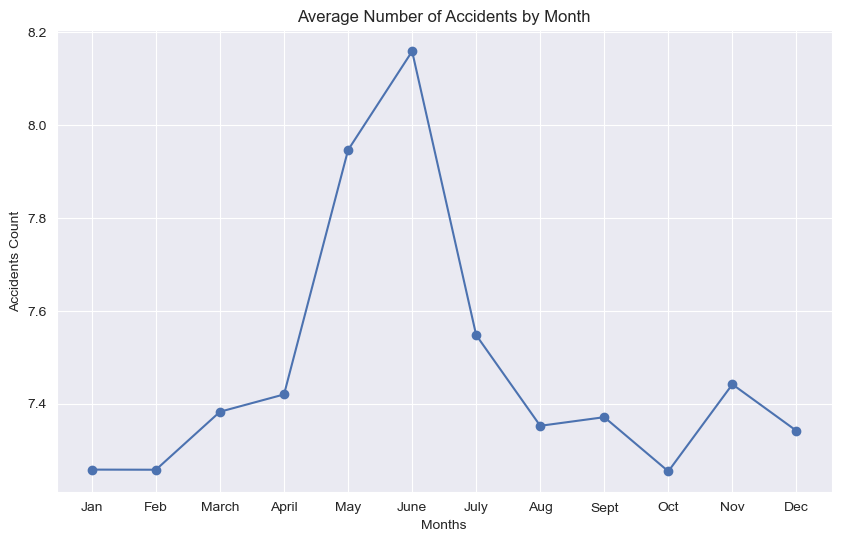

In [16]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.month).mean()

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'Aug',
    9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
data_mean.index = data_mean.index.map(month_mapping)

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-')
plt.xlabel('Months')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Month')
plt.show()

There is a significant spike in the number of recorded accidents from 2016.

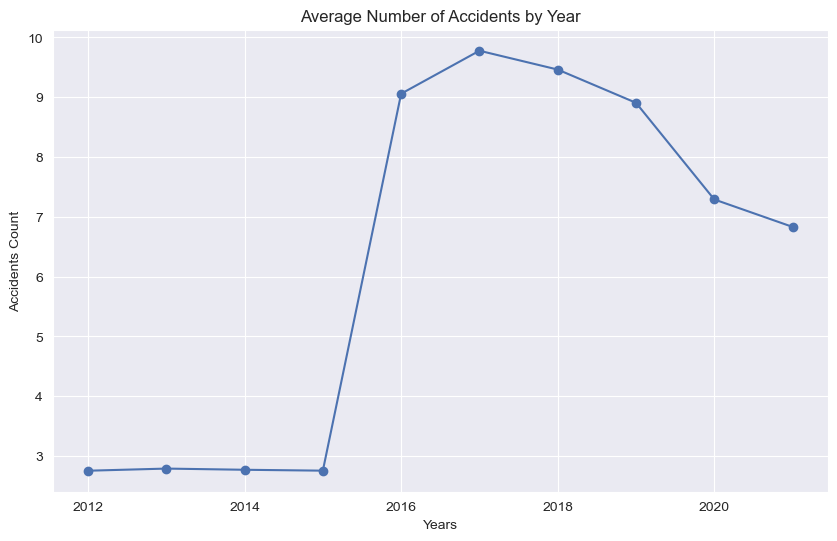

In [17]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.year).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Year')
plt.show()

On average most accidents occur in the middle of the month.

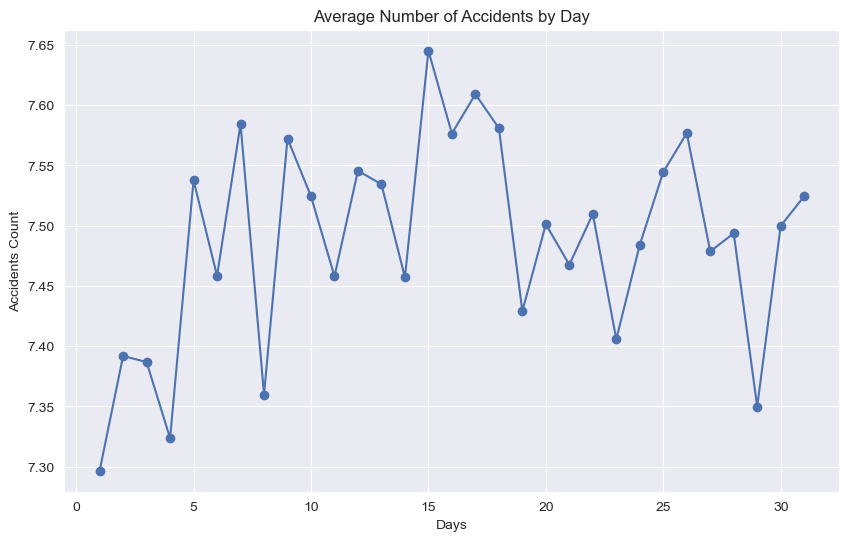

In [18]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.day).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-')
plt.xlabel('Days')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Day')
plt.show()

Most accidents occur at midnight:

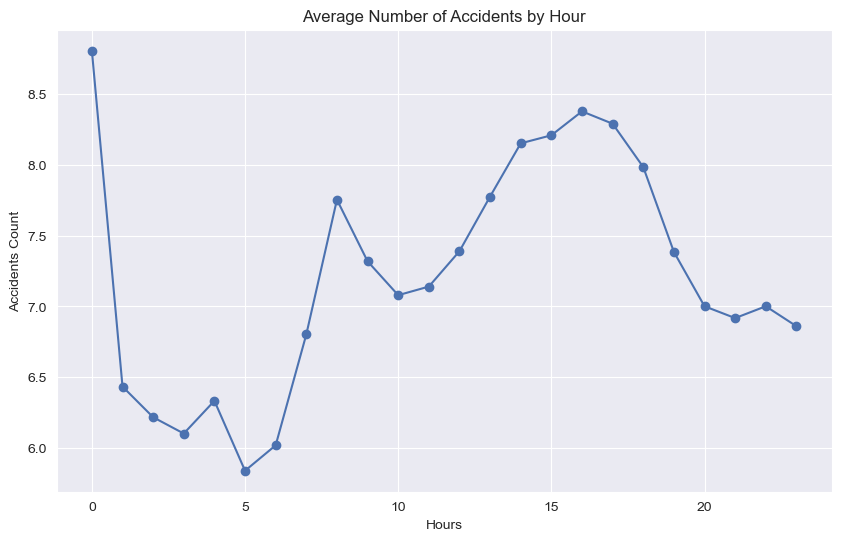

In [19]:
data = df.index.value_counts()
data_mean = data.groupby(data.index.hour).mean()

plt.figure(figsize=(10, 6))
plt.plot(data_mean.index, data_mean, marker='o', linestyle='-')
plt.xlabel('Hours')
plt.ylabel('Accidents Count')
plt.title('Average Number of Accidents by Hour')
plt.show()

Anomaly Detection:

In [20]:
data.head()

crash_datetime
2020-06-30 13:20:00    770
2021-01-15 18:07:00    450
2018-10-17 18:10:00    196
2021-01-21 17:00:00    195
2017-09-04 22:45:00    153
Name: count, dtype: int64

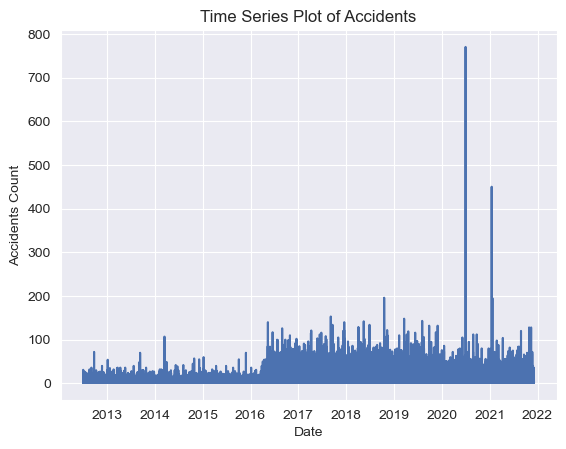

In [21]:
data = df.index.value_counts()

sns.lineplot(x='crash_datetime', y='count', data=data.reset_index())
plt.xlabel('Date')
plt.ylabel('Accidents Count')
plt.title('Time Series Plot of Accidents')
plt.show()

Decompose the time series into its trend, seasonality, and residual components:

In [22]:
data = df.index.value_counts()
data = data.asfreq('D').bfill()

decomposition = seasonal_decompose(data, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

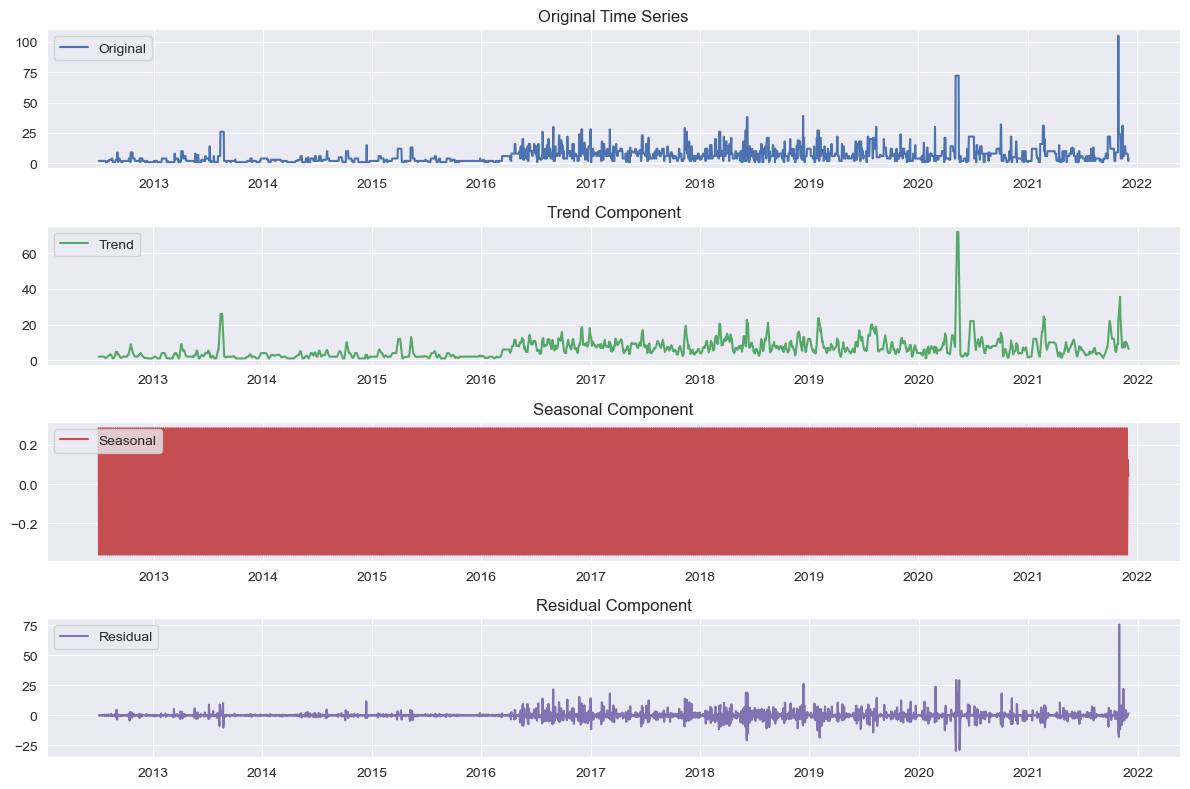

In [23]:
# Plot the original time series
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

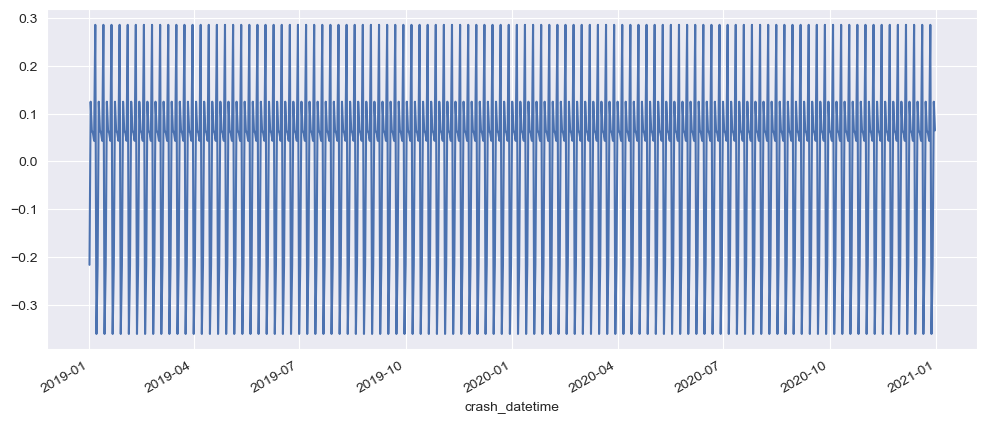

In [24]:
plt.figure(figsize=(12, 5))
decomposition.seasonal["2019":"2020"].plot();

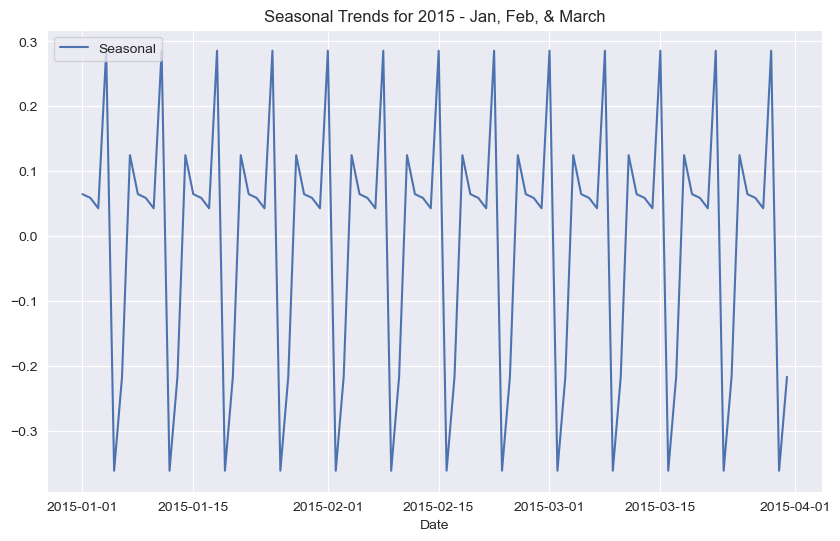

In [25]:
year = 2015
months_to_select = [1, 2, 3]  

selected_data = seasonal[(seasonal.index.year == year) & (seasonal.index.month.isin(months_to_select))]

plt.figure(figsize=(10, 6))
plt.plot(selected_data, label='Seasonal')
plt.xlabel('Date')
plt.title(f'Seasonal Trends for {year} - Jan, Feb, & March')
plt.legend(loc='upper left')
plt.show()

When the seasonal plot is reduced to its lowest form, it shows a weekly spike and subsequent drop in accidents:

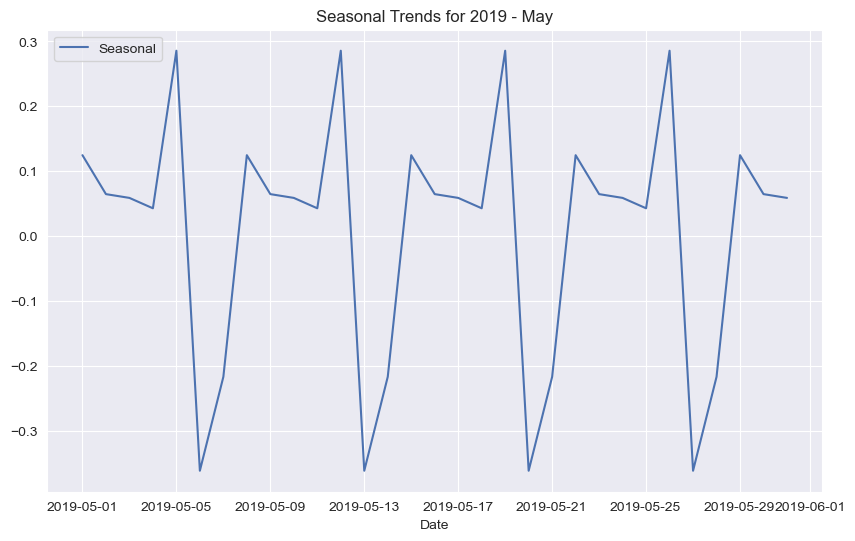

In [26]:
year = 2019
months_to_select = [5]

selected_data = seasonal[(seasonal.index.year == year) & (seasonal.index.month.isin(months_to_select))]

plt.figure(figsize=(10, 6))
plt.plot(selected_data, label='Seasonal')
plt.xlabel('Date')
plt.title(f'Seasonal Trends for {year} - May')
plt.legend(loc='upper left')
plt.show()

Let's plot seasonality for each borough:

In [27]:
seasonality_dict = {}

for bor in df.borough.unique():
    data = df.loc[df.borough==bor].index.value_counts()
    data = data.asfreq('D').bfill()
    decompositions = seasonal_decompose(data.dropna())
    seasonality_dict[bor] = decompositions.seasonal


In [28]:
pd.DataFrame(seasonality_dict)

,Manhattan,Bronx,Brooklyn,Queens,Staten Island
crash_datetime,,,,,
2012-07-01 00:30:00,0.251637,NaN,NaN,NaN,NaN
2012-07-01 01:00:00,NaN,-0.052536,NaN,NaN,NaN
2012-07-01 01:10:00,NaN,NaN,0.066494,NaN,NaN
2012-07-01 02:01:00,NaN,NaN,NaN,-0.010485,NaN
2012-07-01 02:30:00,NaN,NaN,NaN,NaN,0.01215
...,...,...,...,...,...
2021-11-27 00:30:00,0.020913,NaN,NaN,NaN,NaN
2021-11-28 00:30:00,0.251637,NaN,NaN,NaN,NaN
2021-11-29 00:30:00,-0.053388,NaN,NaN,NaN,NaN


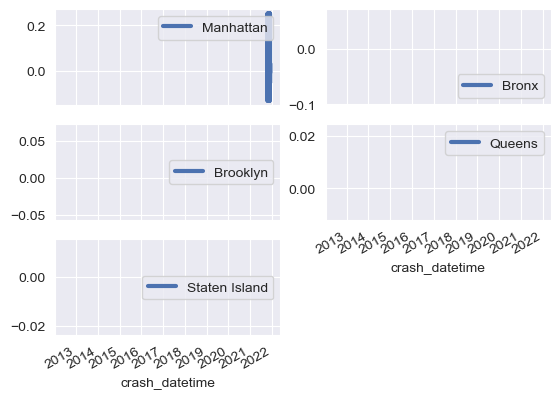

In [29]:
pd.DataFrame(seasonality_dict).plot(
    subplots=True, layout=(3, 2), linewidth=3
);

In [30]:
for bor in df.borough.unique():
    print(bor, df.loc[df.borough==bor].index.value_counts().shape)

Manhattan (92616,)
Bronx (70829,)
Brooklyn (142824,)
Queens (123642,)
Staten Island (20071,)


In [31]:
df.loc[df.borough=='Brooklyn'].head()

,collision_id,borough,zip_code,latitude,longitude,person_type,person_sex,person_injury,person_age,state_registration,...,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,ejection,emotional_status,bodily_injury,position_in_vehicle
crash_datetime,,,,,,,,,,,,,,,,,,,,,
2012-07-01 01:10:00,147450,Brooklyn,11226,40.639624,-73.954769,Pedestrian,U,Injured,18,Ny,...,1,0,0,0,0,0,NaN,NaN,NaN,NaN
2012-07-01 02:20:00,116266,Brooklyn,11223,40.608814,-73.972996,Pedestrian,U,Injured,17,Ny,...,2,0,0,0,0,0,NaN,NaN,NaN,NaN
2012-07-01 02:20:00,116266,Brooklyn,11223,40.608814,-73.972996,Pedestrian,U,Injured,25,Ny,...,2,0,0,0,0,0,NaN,NaN,NaN,NaN
2012-07-01 02:45:00,135073,Brooklyn,11226,40.643185,-73.949729,Occupant,U,Injured,24,Ny,...,0,0,0,0,2,0,NaN,NaN,NaN,NaN
2012-07-01 02:45:00,135073,Brooklyn,11226,40.643185,-73.949729,Occupant,U,Injured,21,Ny,...,0,0,0,0,2,0,NaN,NaN,NaN,NaN
